In [1]:
import json
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats

In [2]:
with open("out/first.json") as f:
    data = json.loads(f.read())

In [3]:
def latlongdist(lat1, lon1, lat2, lon2) :
  dy = (lat2-lat1)*math.pi/180*6.371e6;
  dx = (lon2-lon1)*math.pi/180*math.sin((90-lat1)*math.pi/180)*6.371e6;
  return dx, dy;

def distlatlong(lat1, lon1, dy, dx):#fix deg-rad you idiot
  lat2 = lat1+dy/6.371e6;
  lon2 = lon1+dx/(math.sin((90-lat1)*math.pi/180)*6.371e6);
  return lat2, lon2;


In [4]:
filtered = list(filter(lambda x:x["frame_type"]=="data_message" and x["name"]=="record" and x["fields"][1]["value"] is not None, data))

In [5]:
origin = (filtered[0]["fields"][1]["value"], filtered[0]["fields"][2]["value"])

In [6]:
mine = [{"lat":i["fields"][1]["value"], 
        "long":i["fields"][2]["value"], 
        "time":i["fields"][0]["raw_value"]+631065600, 
        "dx":latlongdist(origin[0], origin[1], i["fields"][1]["value"], i["fields"][2]["value"])[0],
        "dy":latlongdist(origin[0], origin[1], i["fields"][1]["value"], i["fields"][2]["value"])[1],
        "acc":0,
        } for i in filtered]

In [7]:
mine[2]

{'lat': 55.660661179572344,
 'long': 12.075602877885103,
 'time': 1597566367,
 'dx': 13.28043444807635,
 'dy': 5.312543117316312,
 'acc': 0}

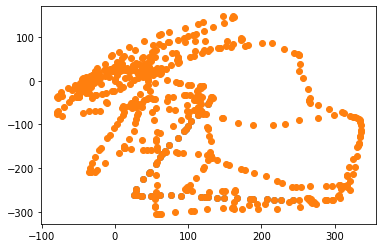

In [8]:
fig = plt.figure()
plt.ion()

ax = fig.add_subplot(111)

minecrop = mine[380:420]
ax.scatter([i["dx"] for i in minecrop], [i["dy"] for i in minecrop])
ax.scatter([i["dx"] for i in mine], [i["dy"] for i in mine])
# ax.scatter(posnon[:,0], posnon[:,1])
plt.show()

In [9]:
def edgelinker(listy, threshold=0.1):
    if len(listy)<3:
        return [listy]
    start, end = np.asarray([listy[0]["dx"],listy[0]["dy"]]), np.asarray([listy[-1]["dx"],listy[-1]["dy"]])

    #find a point that does not lie on the line between the points start and end
    #we probably want to start halfway between and work out to get higher quality ones or just find the furthest one lol
    maxi = None
    maxim = -1
    # line = ((start["dy"]-end["dy"])/(start["dx"]-end["dx"]),)
    for i in range(2, len(listy)-2):

        point = np.asarray([listy[i]["dx"], listy[i]["dy"]])
        dist = abs(np.cross(point-start, end-start)/np.linalg.norm(start-end))
        # print(dist)
        if dist > maxim:
            maxim = dist
            maxi = i
    if maxim > threshold * np.linalg.norm(start-end):
        # print(maxim)
        before = listy[:maxi]
        after = listy[maxi:]
        return edgelinker(before, threshold) + edgelinker(after, threshold)
    else:
        # print(len(listy), maxim,threshold * np.linalg.norm(start-end), threshold)
        return [listy]

In [10]:
def plotter(yeet):
    # print("yeet")
    fig2 = plt.figure()

    ax = fig2.add_subplot(111)
    
    # ax.scatter(posnon[:,0], posnon[:,1])
    for i in range(len(yeet)):
        
        ax.scatter([x["dx"] for x in yeet[i]], [x["dy"] for x in yeet[i]], label = str(i))
    # fig2.legend(loc = "upper left")
    fig2.show()

In [11]:
def summarise(tack):
    dist = ((tack[0]["dx"]-tack[-1]["dx"])**2+(tack[0]["dy"]-tack[-1]["dy"])**2)**.5
    time = (tack[-1]["time"]- tack[0]["time"])
    return (dist, dist/time if time > 0 else "None", time)

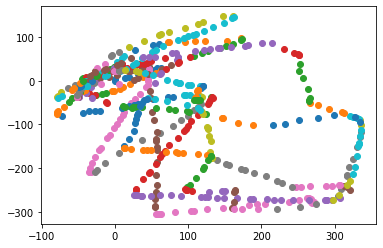

In [12]:
plotter(edgelinker(mine, 0.05)[::])
# print(edgelinker(mine)[3])
# list(zip(list(map(summarise, edgelinker(mine, 0.05))), edgelinker(mine, 0.05)))